# USA Car Accidents Severity Prediction

# 1) PREPROCESSING

In [1]:
! pip install statsmodels

In [2]:
import os
import io
import re
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from scipy.stats import chi2_contingency, chi2
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import scipy.stats as stats

## 1.1) Loading the Dataset

In [3]:
dataf = pd.read_csv('US_Accidents_March23.csv')
display(dataf.head(10))

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


## 1.2) Reporting Sources
    
These data came from two sources, *MapQuest* and *Bing*, both of which report severity level but in a different way.

We decided to select *MapQuest* because serious accidents are we really care about and the sparse data of such accidents is the reality we have to confront.

So we drop the data points reported from *Bing* and the 'Source' column as well.

In [4]:
df = dataf[dataf['Source'] == 'Source1']
df = df.drop(columns=['Source'])

## 1.3) Removing Useless Features
- The 'ID' feature doesn’t provide useful information about the accidents.  
- The features `Distance(mi)`, `End_Time`, `End_Lat`, and `End_Lng` can only be collected after an accident has occurred, so they can't help predict serious accidents.  
- Additionally, the `Description` feature already has relevant points of interest extracted by the dataset creators. We remove these features.
- We also drop `Zipcode`, `Timezone`, `Wind_Chill(F)`, `Wind_Direction` and `Weather_Timestamp` columns since we don't want to perform hypothesis testing on these columns.

In [5]:
print(df.columns)

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [6]:
df = df.drop(['ID','Description','Distance(mi)', 'End_Time','End_Lat', 'End_Lng',
              'Zipcode', 'Timezone', 'Weather_Timestamp',
              'Wind_Chill(F)', 'Wind_Direction'], axis=1)

Viewing the categorical features.

In [7]:
categorical_names = ['Country', 'Amenity', 'Bump', 'Crossing', 
             'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 
             'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

print("Unique count of categorical features:\n")
for i in categorical_names:
  print(i,"-", df[i].unique().size)

Unique count of categorical features:

Country - 1
Amenity - 2
Bump - 2
Crossing - 2
Give_Way - 2
Junction - 2
No_Exit - 2
Railway - 2
Roundabout - 2
Station - 2
Stop - 2
Traffic_Calming - 2
Traffic_Signal - 2
Turning_Loop - 1
Sunrise_Sunset - 3
Civil_Twilight - 3
Nautical_Twilight - 3
Astronomical_Twilight - 3


Drop 'Country' and 'Turning_Loop' because they have only one class.

In [8]:
df = df.drop(['Country','Turning_Loop'], axis=1)

## 1.4) Processing Categorical Features
If we look at categorical features closely, we will find confusing values in 'Weather_Condition' and 'Wind_Direction'.

### Weather Condition
Weather-related vehicle accidents cause more annual fatalities than large-scale disasters. The Road Weather Management Program reports that most such crashes occur on wet pavement and during rainfall, with winter conditions and fog also contributing significantly. To analyze these three weather conditions, we will first examine the 'Weather_Condition' feature.

In [9]:
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split("!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Duststorm', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Nearby', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Volcanic

Create features for some common weather conditions and drop 'Weather_Condition' then.

In [10]:
# Clear Weather
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear|Fair', case=False, na=False), True, False)

# Cloudy Weather
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast|Scattered Clouds|Partly Cloudy|Mostly Cloudy', case=False, na=False), True, False)

# Light Rain
df['Light_Rain'] = np.where(df['Weather_Condition'].str.contains('Light Rain|Drizzle|Rain Showers|Showers in the Vicinity|Light Drizzle|Sleet|Light Sleet', case=False, na=False), True, False)

# Heavy Rain
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms|Thunderstorm|Heavy Rain Shower|Heavy Rain Showers|Heavy Sleet', case=False, na=False), True, False)

# Thunderstorm (General Category)
df['Thunderstorm'] = np.where(df['Weather_Condition'].str.contains('T-Storm|Thunderstorm|Thunder|Thunder in the Vicinity|Light Thunderstorms', case=False, na=False), True, False)

# Snow / Ice Conditions
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Ice Pellets|Wintry Mix|Snow Grains|Snow Nearby|Snow Shower|Light Ice Pellets', case=False, na=False), True, False)

# Heavy Snow
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na=False), True, False)

# Fog / Haze / Mist
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog|Haze|Mist|Partial Fog|Shallow Fog|Patches of Fog|Light Fog|Light Haze', case=False, na=False), True, False)

# Dust / Sand / Ash
df['Dust'] = np.where(df['Weather_Condition'].str.contains('Dust|Sand|Volcanic Ash|Widespread Dust|Duststorm|Dust Whirls|Dust Whirls Nearby|Dust Whirlwinds', case=False, na=False), True, False)

# Windy Conditions
df['Wind'] = np.where(df['Weather_Condition'].str.contains('Windy|Blowing|Low Drifting|Drifting Snow', case=False, na=False), True, False)

# Hail
df['Hail'] = np.where(df['Weather_Condition'].str.contains('Hail|Small Hail', case=False, na=False), True, False)

# Tornado
df['Tornado'] = np.where(df['Weather_Condition'].str.contains('Tornado|Funnel Cloud', case=False, na=False), True, False)

# Smoke (Separate Category)
df['Smoke'] = np.where(df['Weather_Condition'].str.contains('Smoke', case=False, na=False), True, False)

In [11]:
# Define the list of new weather categories
weather = ['Clear', 'Cloud', 'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog', 'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke']

# Initialize columns with False for each weather category, including handling missing values
for i in weather:
    df[i] = np.where(df['Weather_Condition'].isnull(), False, df[i].astype('bool'))

# Drop the original 'Weather_Condition' column
df = df.drop(['Weather_Condition'], axis=1)

## 1.5) Fixing Datetime Format

We map 'Start_Time' to 'Year', 'Month', 'Weekday', 'Day' (in a year), 'Hour', and 'Minute' (in a day).

In [12]:
# Remove trailing nanoseconds (if any) in 'Start_Time' columns
df['Start_Time'] = df['Start_Time'].apply(lambda x: re.sub(r"\.0+$", "", str(x)) if pd.notnull(x) else x)

# Convert the cleaned columns to datetime format
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='raise')

# Extract components from 'Start_Time' and create new columns
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Weekday'] = df['Start_Time'].dt.weekday  # 0=Monday, 6=Sunday
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour
df['Minute'] = df['Start_Time'].dt.minute

# Display the new columns to verify
df[['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']].head()

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
3402762,2016-02-08 00:37:08,2016,2,0,8,0,37
3402763,2016-02-08 05:56:20,2016,2,0,8,5,56
3402764,2016-02-08 06:15:39,2016,2,0,8,6,15
3402765,2016-02-08 06:15:39,2016,2,0,8,6,15
3402766,2016-02-08 06:51:45,2016,2,0,8,6,51


# 2) HANDLING MISSING DATA


## 2.1) Separate Features
Add a new feature for missing values in 'Precipitation(in)' and replace missing values with median.


In [13]:
df = df.drop(df[(df['Severity'] == 2) & (df['Precipitation(in)'].isnull())].index)
df['Precipitation_NA'] = 0
df.loc[df['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())

<a id="2.3"></a>
## 2.2) Drop NaN
The counts of missing values in some features are much smaller compared to the total sample. It is convenient to drop rows with missing values in these columns.

Drop NAs by these features:

1. 'City'
2. 'Zipcode'
3. 'Airport_Code'
4. 'Sunrise_Sunset'
5. 'Civil_Twilight'
6. 'Nautical_Twilight'
7. 'Astronomical_Twilight'

In [14]:
df = df.dropna(subset=['City','Airport_Code',
                       'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])

<a id="2.4"></a>
## 2.3) Value Imputation
Rest of the columns only have small missing parts that can be filled.

### Continuous Weather Data
Continuous weather features with missing values:

1. Temperature(F)

2. Humidity(%)

3. Pressure(in)

4. Visibility(mi)

5. Wind_Speed(mph)

The imputation approach involves grouping the data by 'Airport_Code' to ensure geographical relevance, as the weather data originates from airport weather stations, and by 'Start_Month' for computational efficiency and better data retention. Missing values in continuous weather features are then filled using the median of the corresponding groups, providing a robust estimate that is less influenced by outliers. This is implemented through code that applies a lambda function to the grouped DataFrame, effectively filling in missing values with the calculated median for each feature.

In [15]:
Weather_data = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

print("The number of remaining missing values: ")
for feature in Weather_data:
    # Group by 'Airport_Code' and 'Month' and calculate the median within each group
    median_values = df.groupby(['Airport_Code', 'Month'])[feature].transform('median')
    
    # Fill NaNs in each feature column with the calculated median value
    df[feature] = df[feature].fillna(median_values)
    
    # Output the number of remaining NaN values for each feature
    print(f"{feature} : {df[feature].isnull().sum()}")

The number of remaining missing values: 
Temperature(F) : 560
Humidity(%) : 568
Pressure(in) : 524
Visibility(mi) : 6529
Wind_Speed(mph) : 6194


There still are some missing values in the dataset, we just drop these rows for simplicity.

In [16]:
df = df.dropna(subset=Weather_data)
df = pd.concat([df[df['Severity'] == 1], df[df['Severity'] == 2].sample(n=300000, random_state=42), df[df['Severity'] == 3], df[df['Severity'] == 4]])

# 3) Exploratory Data Analysis

In [17]:
print("The shape of our dataset is: ", df.shape)

The shape of our dataset is:  (673653, 51)


## 3.1) Distribution of Accident Severity

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/26877047.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Severity', data=df, palette='viridis')


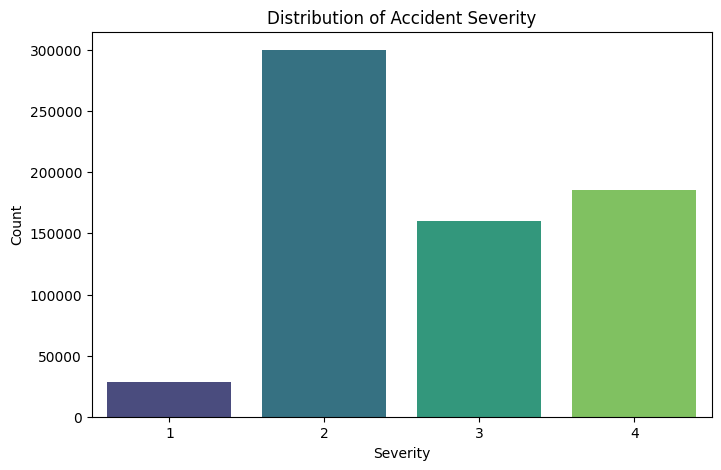

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Severity', data=df, palette='viridis')
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

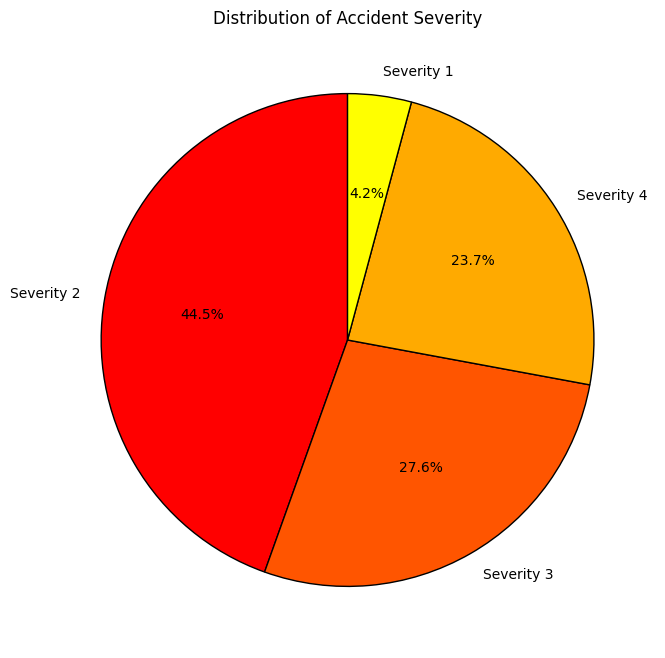

In [19]:
# plot pie chart for the distribution of accident severity
plt.figure(figsize=(8, 8))
df['Severity'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='autumn', wedgeprops={'edgecolor': 'black'}, labels=['Severity 2', 'Severity 3', 'Severity 4', 'Severity 1'])
plt.title("Distribution of Accident Severity")
plt.ylabel('')
plt.show()

In [20]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Street', 'City',
       'County', 'State', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud',
       'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog',
       'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke', 'Year', 'Month', 'Weekday',
       'Day', 'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/869809329.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Severity', y='Temperature(F)', palette="viridis")


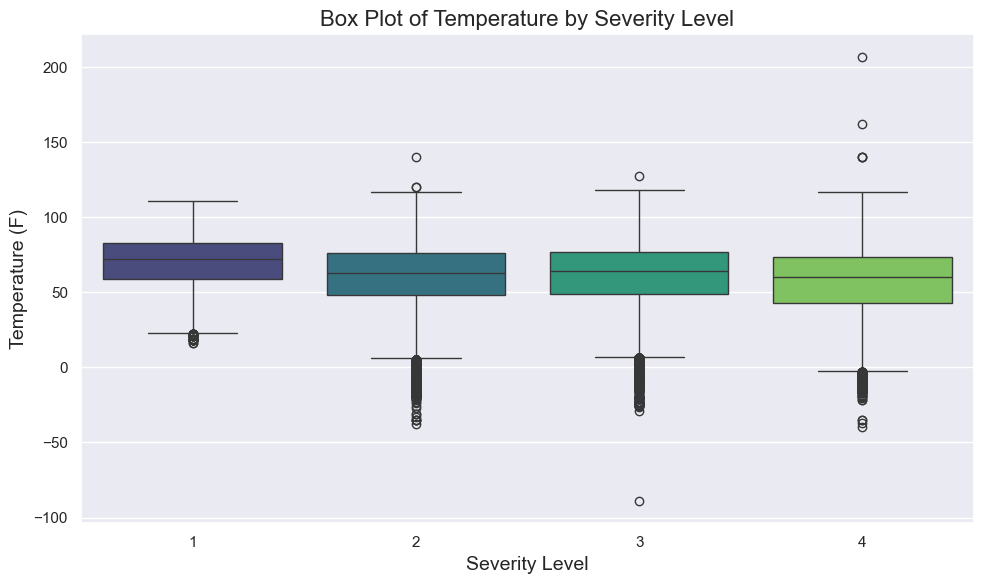

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a colorful style for seaborn
sns.set(style="darkgrid")

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the box plot with a "Spectral" color palette for vibrant colors
sns.boxplot(data=df, x='Severity', y='Temperature(F)', palette="viridis")

# Set title and labels
plt.title("Box Plot of Temperature by Severity Level", fontsize=16)
plt.xlabel("Severity Level", fontsize=14)
plt.ylabel("Temperature (F)", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


## 3.2) Accidents by Weather Conditions

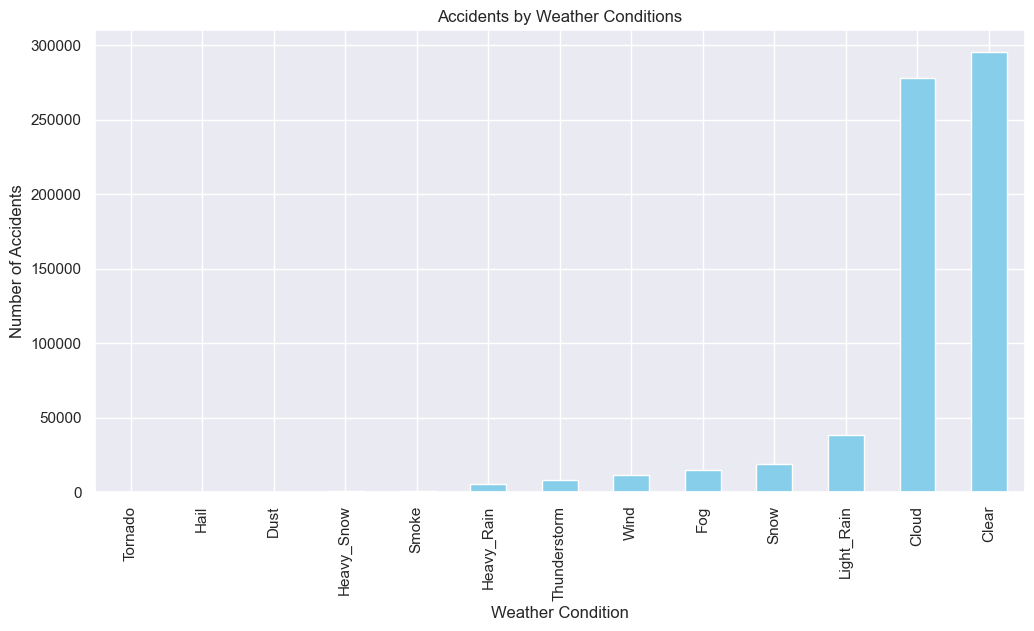

In [22]:
# Melt the weather-related columns for plotting
weather_columns = ['Clear', 'Cloud', 'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog', 'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke']
weather_data = df[weather_columns].melt(var_name="Weather_Condition", value_name="Presence")
weather_counts = weather_data[weather_data['Presence']].groupby('Weather_Condition').size()

# Plot accident counts by weather condition
plt.figure(figsize=(12, 6))
weather_counts.sort_values().plot(kind='bar', color='skyblue')
plt.title("Accidents by Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.show()

## 3.3) Temporal Patterns: Accidents by Hour

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/3038877931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='plasma')


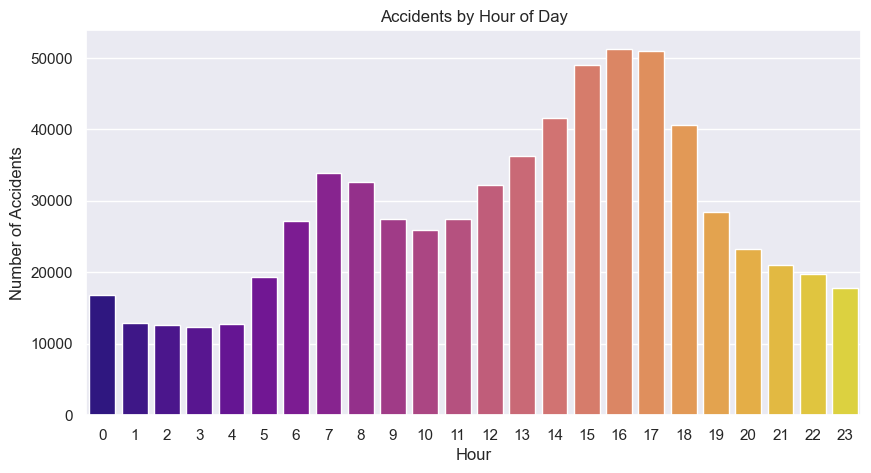

In [23]:
# Plot accident count by hour
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df, palette='plasma')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.show()

## 3.4) Accidents by Day of the Week

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/560656328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weekday', data=df, palette='cividis')


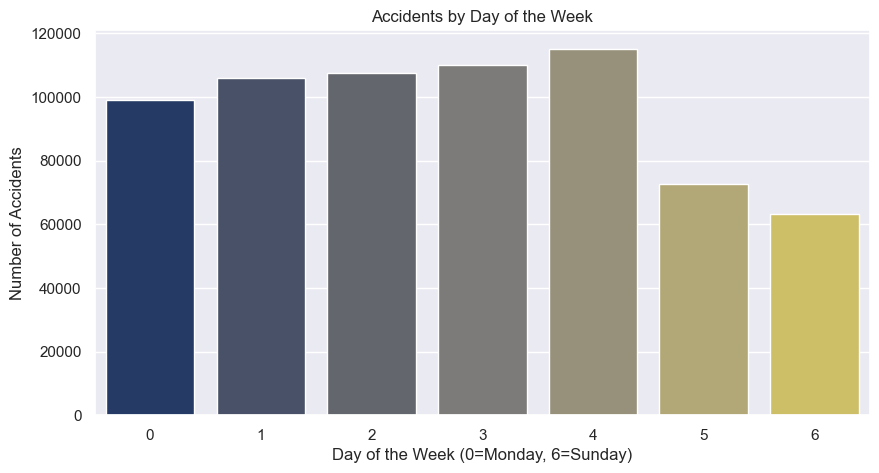

In [24]:
# Plot accidents by day of the week
plt.figure(figsize=(10, 5))
sns.countplot(x='Weekday', data=df, palette='cividis')
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

## 3.5) Accidents by Month

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/470108380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=df, palette='cool')


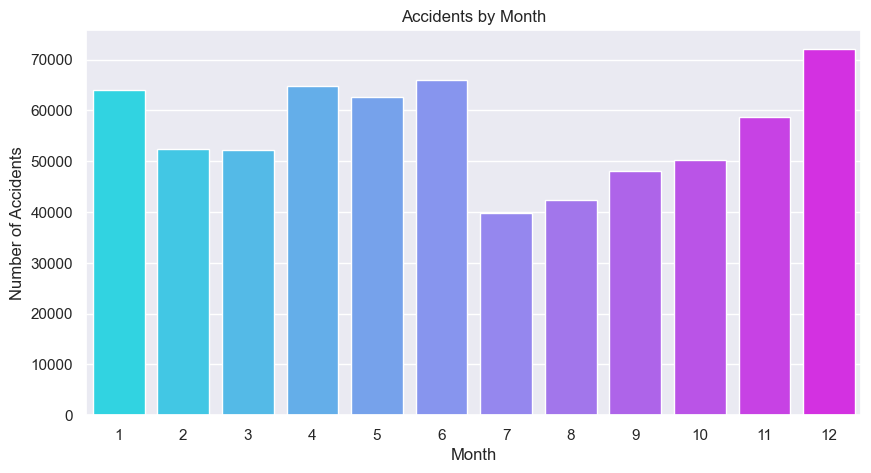

In [25]:
# Plot accidents by month
plt.figure(figsize=(10, 5))
sns.countplot(x='Month', data=df, palette='cool')
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.show()

## 3.6) Accidents vs. Temperature

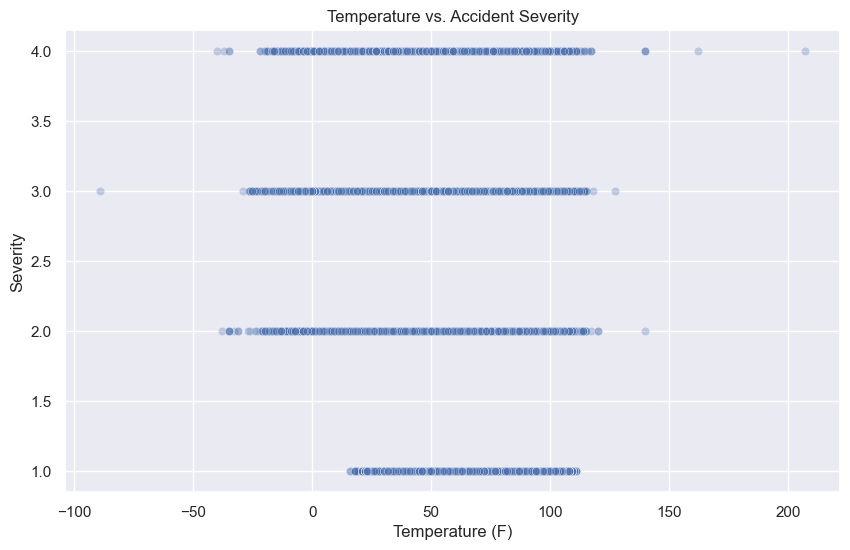

In [26]:
# Scatter plot of temperature vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature(F)', y='Severity', data=df, alpha=0.3)
plt.title("Temperature vs. Accident Severity")
plt.xlabel("Temperature (F)")
plt.ylabel("Severity")
plt.show()

## 3.7) Accidents vs. Visibility

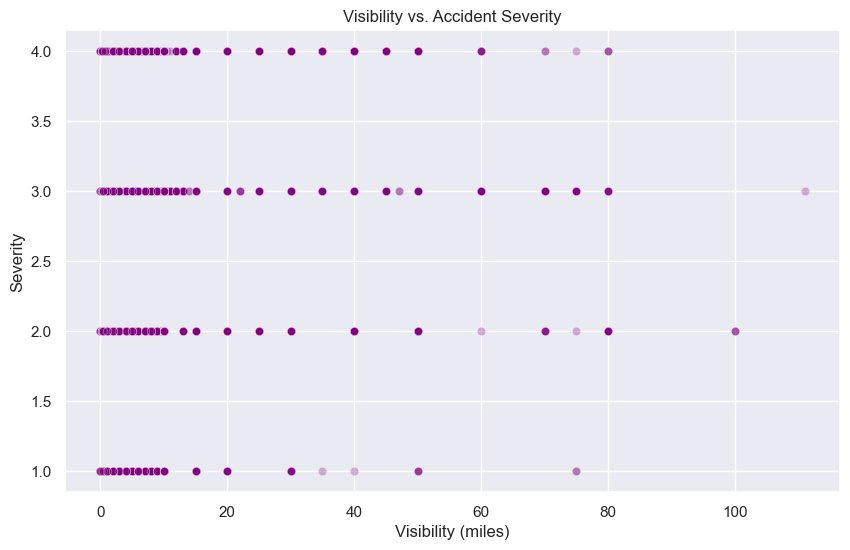

In [27]:
# Scatter plot of visibility vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Visibility(mi)', y='Severity', data=df, alpha=0.3, color='purple')
plt.title("Visibility vs. Accident Severity")
plt.xlabel("Visibility (miles)")
plt.ylabel("Severity")
plt.show()

In [28]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Street', 'City',
       'County', 'State', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud',
       'Light_Rain', 'Heavy_Rain', 'Thunderstorm', 'Snow', 'Heavy_Snow', 'Fog',
       'Dust', 'Wind', 'Hail', 'Tornado', 'Smoke', 'Year', 'Month', 'Weekday',
       'Day', 'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')

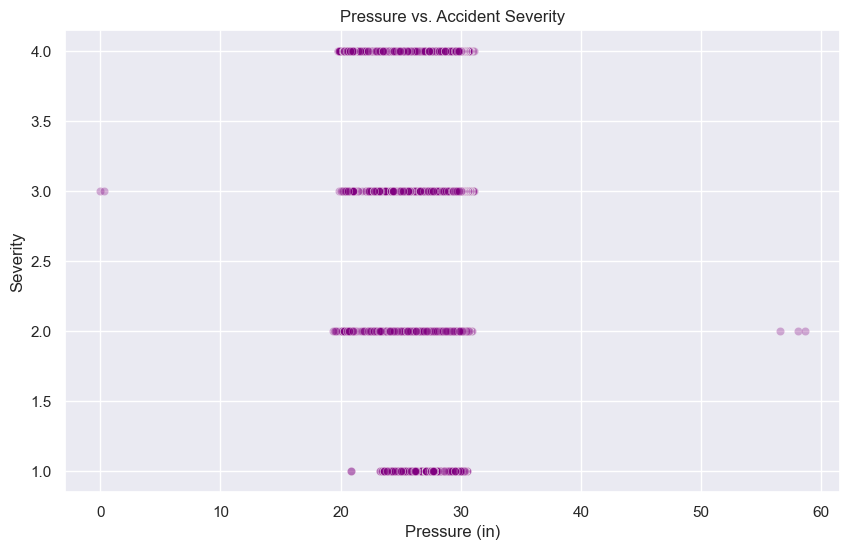

In [29]:
# Scatter plot of visibility vs. accident severity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pressure(in)', y='Severity', data=df, alpha=0.3, color='purple')
plt.title("Pressure vs. Accident Severity")
plt.xlabel("Pressure (in)")
plt.ylabel("Severity")
plt.show()

## 3.8) Accidents by State

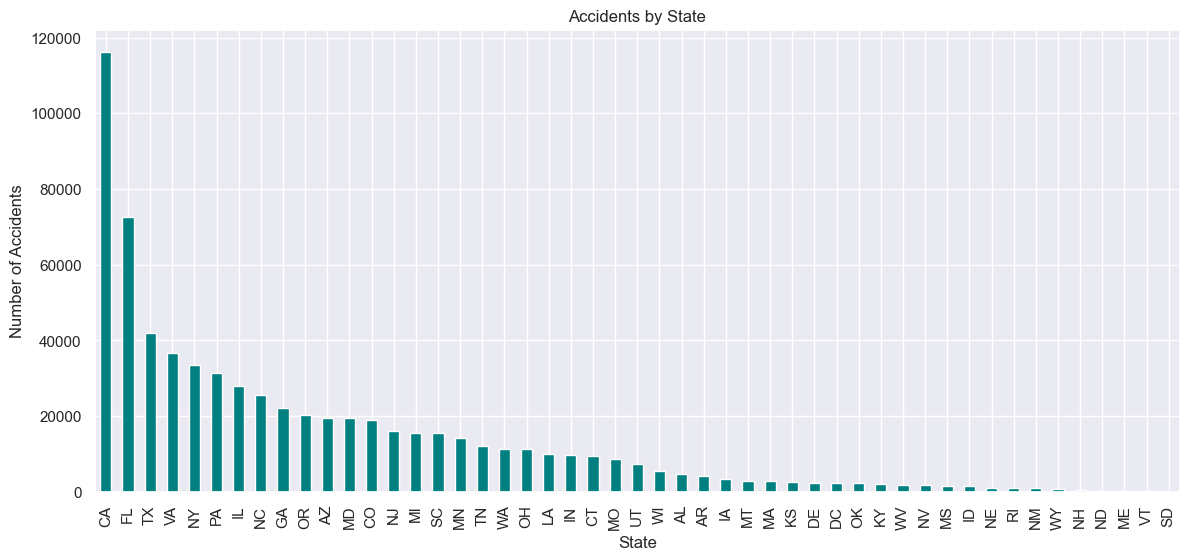

In [30]:
# Plot accident count by state
plt.figure(figsize=(14, 6))
df['State'].value_counts().plot(kind='bar', color='teal')
plt.title("Accidents by State")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.show()

## 3.9) Accidents by Humidity Levels

/var/folders/bb/0zytj09s77ncbwkyc_fxkzm80000gn/T/ipykernel_43110/2720265650.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Humidity(%)'], bins=30, kde=True, color='darkblue')


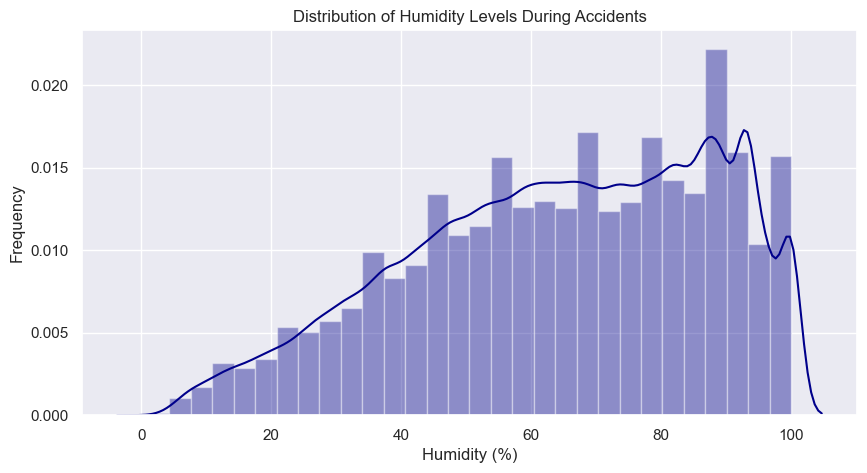

In [31]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Humidity(%)'], bins=30, kde=True, color='darkblue')
plt.title("Distribution of Humidity Levels During Accidents")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

## 3.10) Accidents by POI

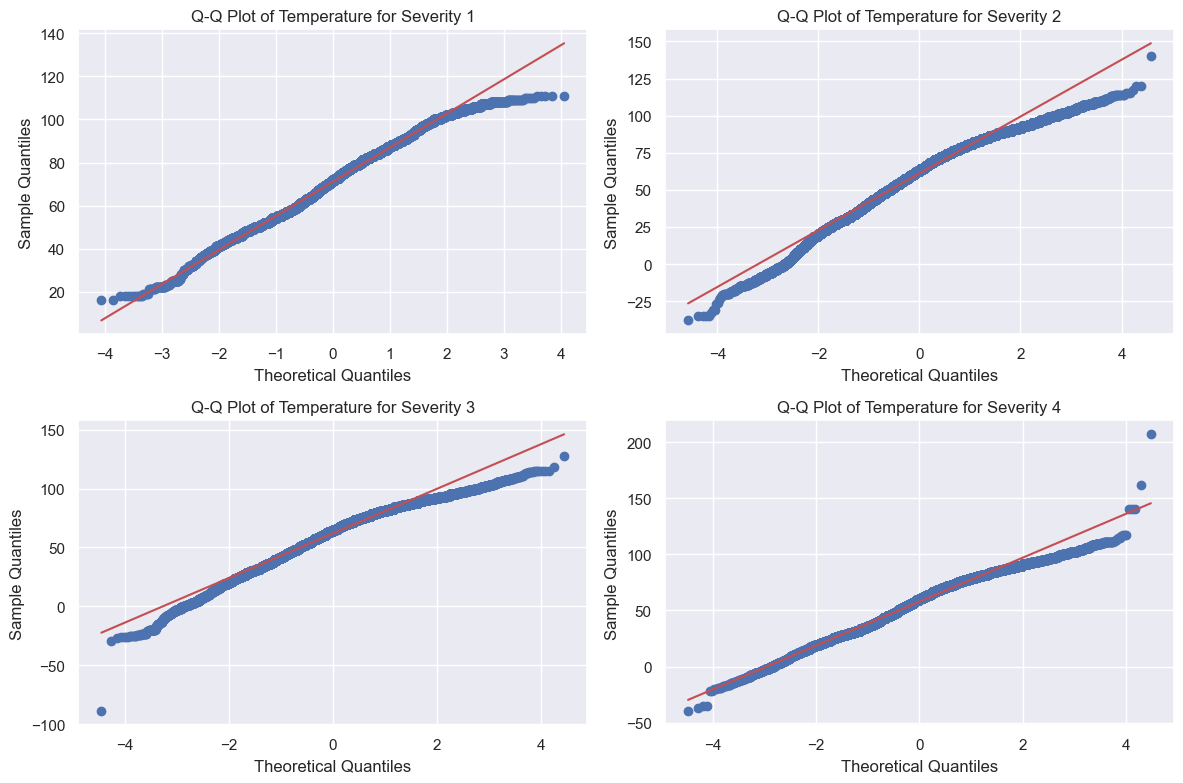

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set up the figure for subplots
severity_levels = df['Severity'].unique()
plt.figure(figsize=(12, 8))

# Generate a Q-Q plot for Temperature for each Severity level
for i, level in enumerate(severity_levels, 1):
    plt.subplot(2, 2, i)  # Adjust subplot grid if needed
    severity_temp = df[df['Severity'] == level]['Temperature(F)'].dropna()
    
    # Create the Q-Q plot
    stats.probplot(severity_temp, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Temperature for Severity {level}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


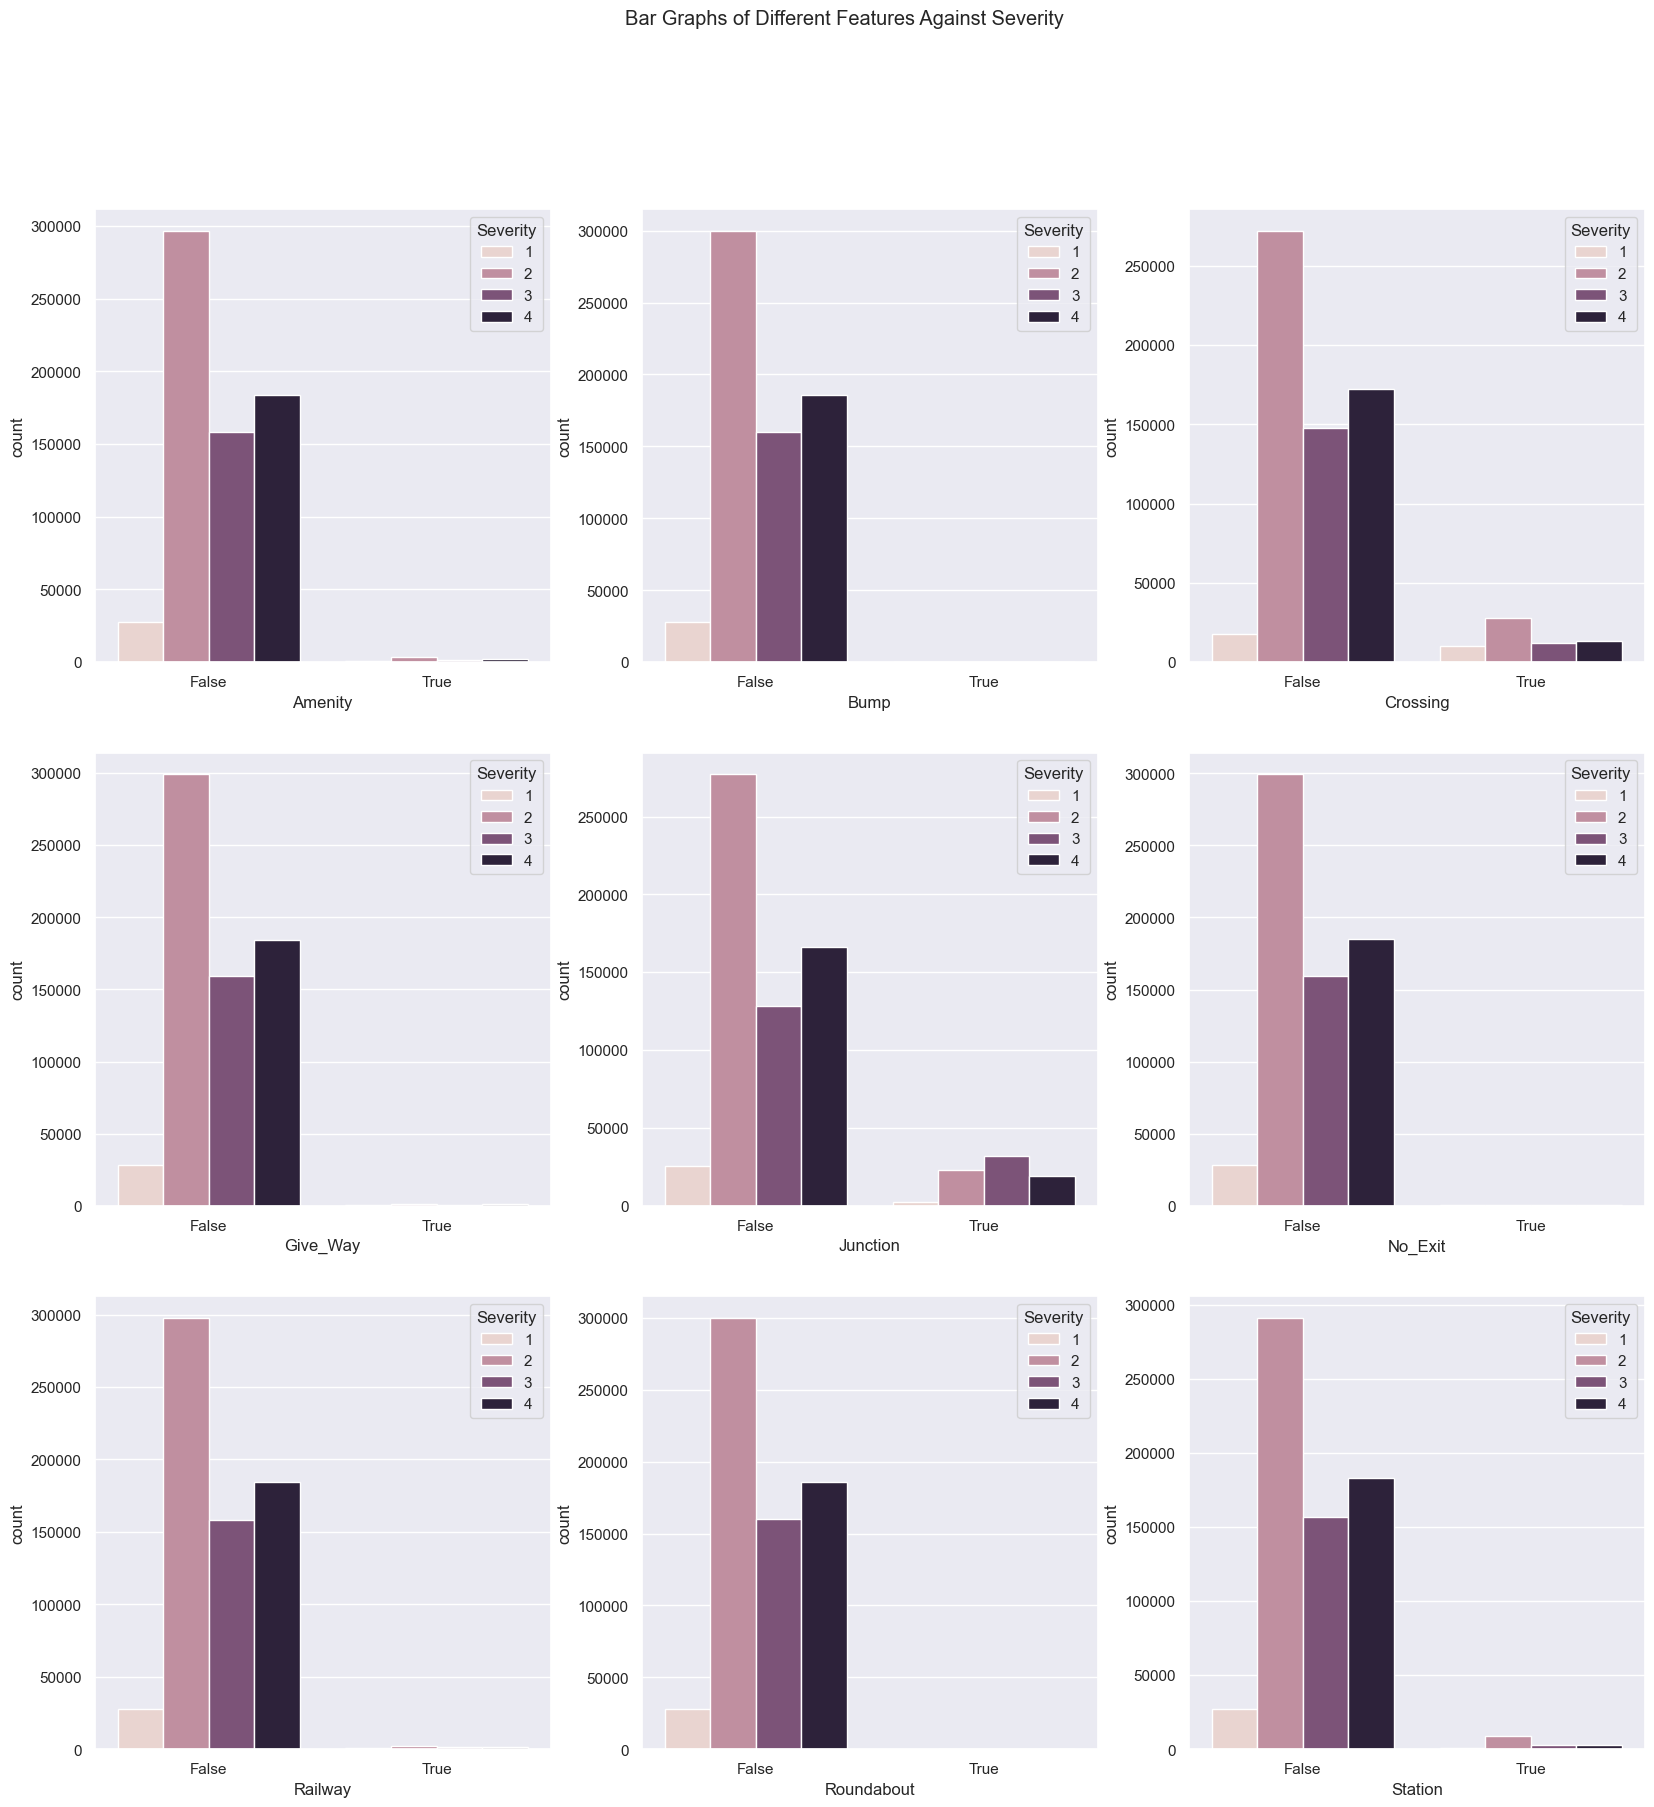

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Bar Graphs of Different Features Against Severity')

# Use df_balanced instead of df
sns.countplot(x='Amenity', hue='Severity', data=df, ax=axs[0, 0])
sns.countplot(x='Bump', hue='Severity', data=df, ax=axs[0, 1])
sns.countplot(x='Crossing', hue='Severity', data=df, ax=axs[0, 2])
sns.countplot(x='Give_Way', hue='Severity', data=df, ax=axs[1, 0])
sns.countplot(x='Junction', hue='Severity', data=df, ax=axs[1, 1])
sns.countplot(x='No_Exit', hue='Severity', data=df, ax=axs[1, 2])
sns.countplot(x='Railway', hue='Severity', data=df, ax=axs[2, 0])
sns.countplot(x='Roundabout', hue='Severity', data=df, ax=axs[2, 1])
sns.countplot(x='Station', hue='Severity', data=df, ax=axs[2, 2])

# Show the plots
plt.show()

# 4) Hypothesis Testing

## 4.1) Chi Square Test for Independence

Chi-Square Test for 'Severity' and 'Roundabout':
  Chi2 Statistic: 2.67, p-value: 0.44531784204395286
  Result: Null hypothesis accepted (no significant association)


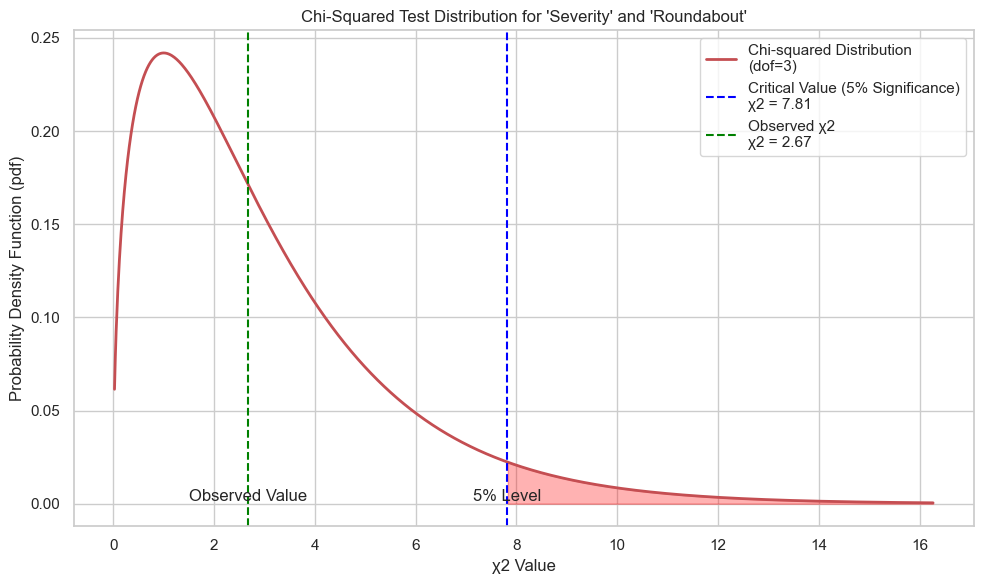

  Cells with expected frequency < 5: 3/8
--------------------------------------------------
Chi-Square Test for 'Severity' and 'Heavy_Rain':
  Chi2 Statistic: 311.34, p-value: 3.486379355585606e-67
  Result: Null hypothesis rejected (significant association)


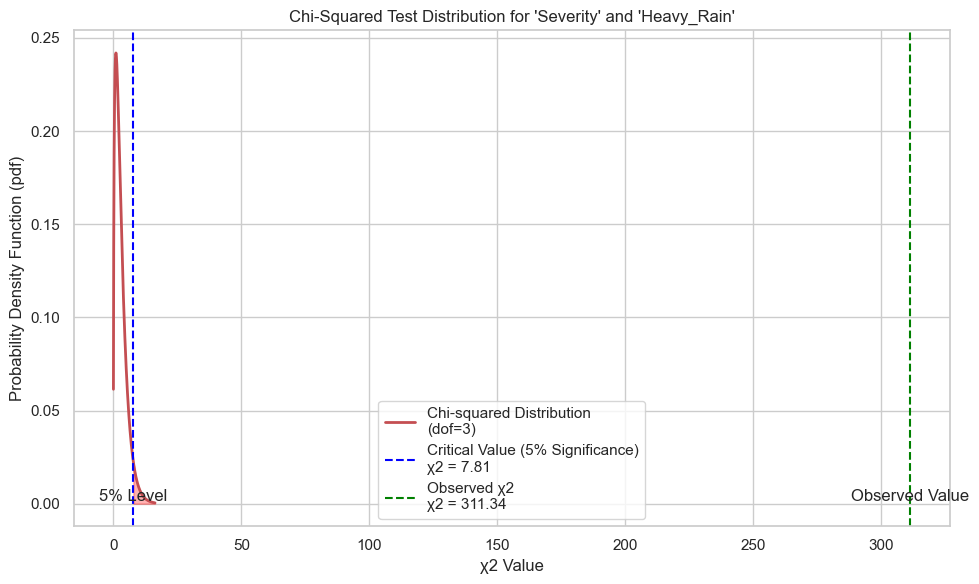

  Cells with expected frequency < 5: 0/8
--------------------------------------------------
Chi-Square Test for 'Severity' and 'Fog':
  Chi2 Statistic: 741.00, p-value: 2.6982929102789063e-160
  Result: Null hypothesis rejected (significant association)


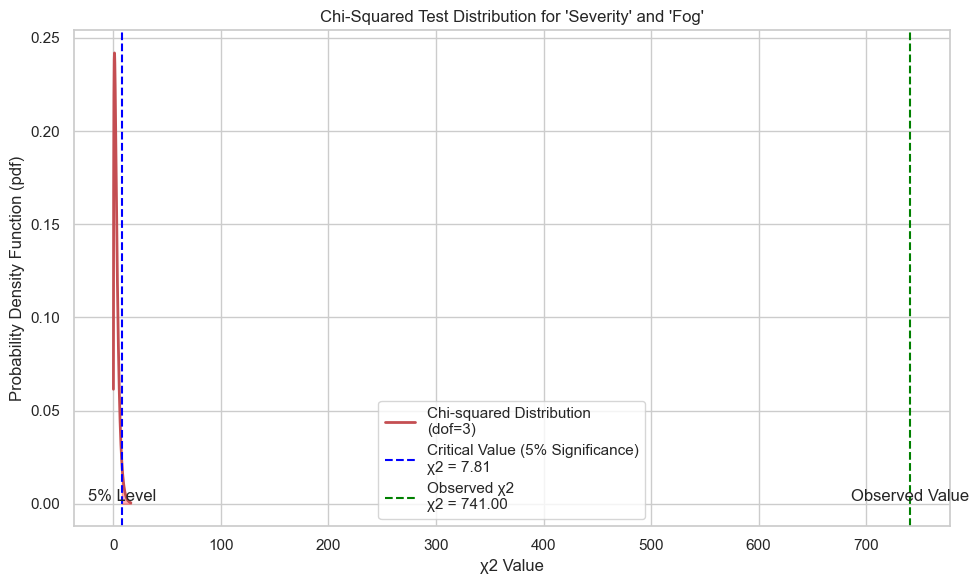

  Cells with expected frequency < 5: 0/8
--------------------------------------------------


In [34]:
from scipy.stats import chi2, chi2_contingency

# List of boolean columns to test against 'Severity'
boolean_columns = ['Roundabout', 'Heavy_Rain', 'Fog']

# Significance level
alpha = 0.05

# Loop over each boolean column, perform the Chi-square test, and print results
for column in boolean_columns:
    contingency_table = pd.crosstab(df['Severity'], df[column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test for 'Severity' and '{column}':")
    print(f"  Chi2 Statistic: {chi2_stat:.2f}, p-value: {p_value}")

    # Interpret the result based on the p-value and alpha
    if p_value < alpha:
        print("  Result: Null hypothesis rejected (significant association)")
    else:
        print("  Result: Null hypothesis accepted (no significant association)")
    
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Values for x-axis
    x = np.linspace(chi2.ppf(0.001, dof), chi2.ppf(0.999, dof), 1000)
    
    # Plot chi-squared distribution
    plt.plot(x, chi2.pdf(x, dof), 'r-', lw=2, label=f'Chi-squared Distribution\n(dof={dof})')
    
    # Highlight the region beyond the critical value for 5% significance
    critical_value = chi2.ppf(0.95, dof)
    plt.fill_between(x, chi2.pdf(x, dof), where=(x > critical_value), color="red", alpha=0.3)
    
    # Annotate the 5% critical value
    plt.axvline(critical_value, color='blue', linestyle='--', label=f'Critical Value (5% Significance)\nχ2 = {critical_value:.2f}')
    plt.text(critical_value, 0, '5% Level', horizontalalignment='center', verticalalignment='bottom')
    
    # Annotate the computed chi2 statistic
    plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed χ2\nχ2 = {chi2_stat:.2f}')
    plt.text(chi2_stat, 0, 'Observed Value', horizontalalignment='center', verticalalignment='bottom')
    
    # Add title and labels
    plt.title(f"Chi-Squared Test Distribution for 'Severity' and '{column}'")
    plt.xlabel("χ2 Value")
    plt.ylabel("Probability Density Function (pdf)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Validation Experiment - Expected Frequency Check
    count_low_freq = (expected < 5).sum()
    total_cells = expected.size
    print(f"  Cells with expected frequency < 5: {count_low_freq}/{total_cells}")
    print("-" * 50)

    # Bootstrapping for Consistency Check
    # print(f"Bootstrap Consistency Test for 'Severity' and '{column}'...")
    # n_iterations = 1000
    # p_values_bootstrap = []

    # for _ in range(n_iterations):
    #     bootstrap_sample = df.sample(frac=0.8, replace=True)
    #     bootstrap_contingency = pd.crosstab(bootstrap_sample['Severity'], bootstrap_sample[column])
    #     _, p_bootstrap, _, _ = chi2_contingency(bootstrap_contingency)
    #     p_values_bootstrap.append(p_bootstrap)

    # # Plot distribution of bootstrapped p-values
    # plt.hist(p_values_bootstrap, bins=30, color='skyblue', edgecolor='black')
    # plt.xlabel('P-value')
    # plt.ylabel('Frequency')
    # plt.title(f'Distribution of P-values from Bootstrapping for {column}')
    # plt.axvline(x=alpha, color='red', linestyle='--', label='Significance Level (alpha = 0.05)')
    # plt.legend()
    # plt.show()
    
    # print("\n")


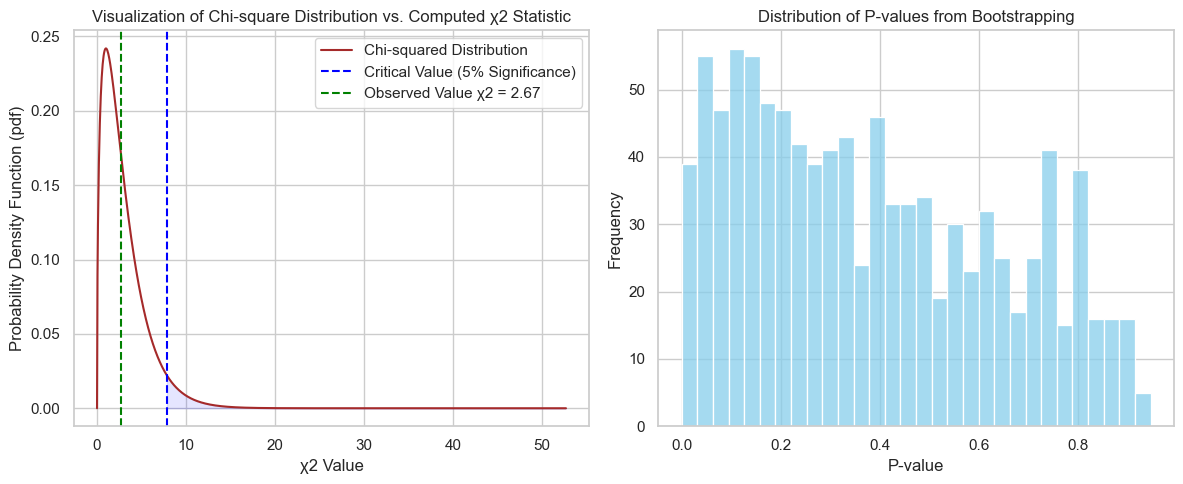

The original Chi-square test does not indicate a significant association (p-value = 0.44531784204395286).
Mean of Bootstrap P-values: 0.3828010585817585
95% Confidence Interval of P-values: (0.020719590888654323, 0.8725863756486735)
Bootstrap analysis does not confirm a significant association.


In [35]:
# Initialize variables
column_to_test = 'Roundabout'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

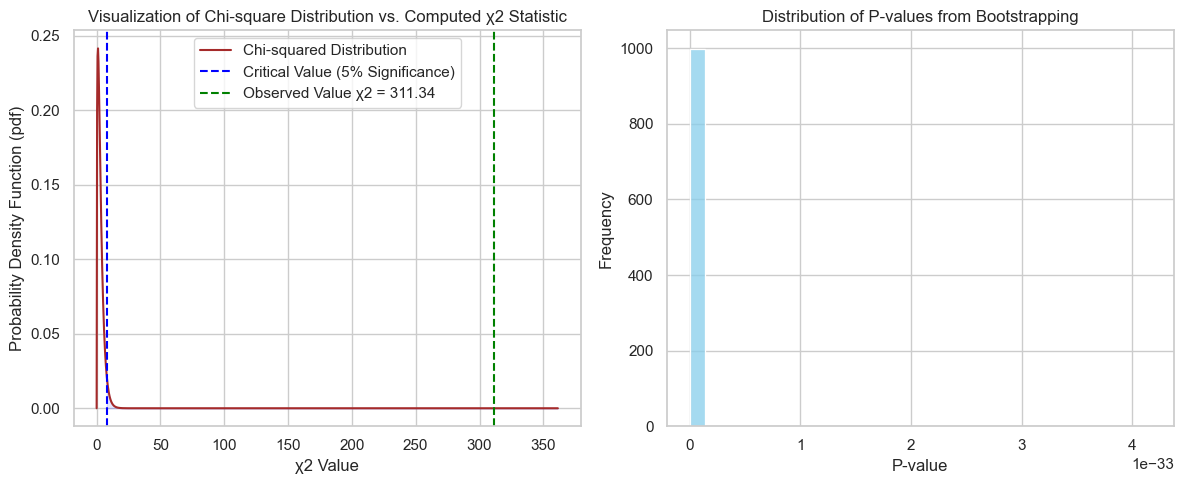

The original Chi-square test indicates a significant association (p-value = 3.486379355585606e-67).
Mean of Bootstrap P-values: 9.063589249697211e-36
95% Confidence Interval of P-values: (1.1938867775372143e-68, 1.5587363423599275e-40)
Bootstrap analysis confirms a significant association.


In [36]:
# Initialize variables
column_to_test = 'Heavy_Rain'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

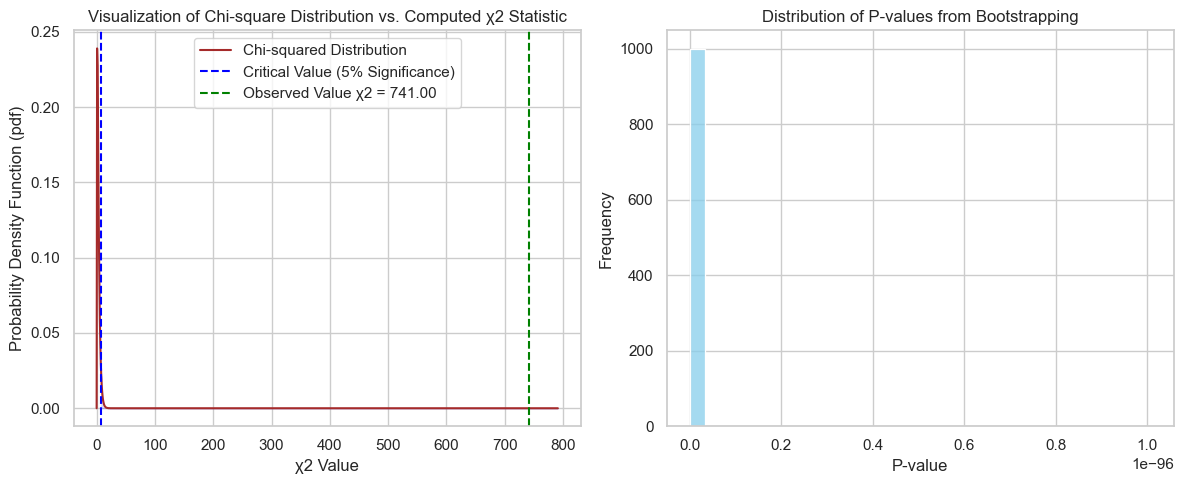

The original Chi-square test indicates a significant association (p-value = 2.6982929102789063e-160).
Mean of Bootstrap P-values: 1.0079398452922728e-99
95% Confidence Interval of P-values: (1.6981253263099582e-148, 2.3795334932469725e-109)
Bootstrap analysis confirms a significant association.


In [37]:
# Initialize variables
column_to_test = 'Fog'  # Choose one boolean column to test against 'Severity'
alpha = 0.05  # Significance level
n_bootstraps = 1000  # Number of bootstrap samples

# Step 1: Perform the original Chi-square test
contingency_table = pd.crosstab(df['Severity'], df[column_to_test])
chi2_stat, p_value, dof, _ = chi2_contingency(contingency_table)

# Step 2: Plot Chi-square distribution with observed statistic
x_values = np.linspace(0, chi2_stat + 50, 1000)  # Extend slightly beyond observed value
chi2_pdf = chi2.pdf(x_values, dof)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, chi2_pdf, color='brown', label='Chi-squared Distribution')
plt.axvline(chi2.ppf(1 - alpha, dof), color='blue', linestyle='--', label=f'Critical Value (5% Significance)')
plt.axvline(chi2_stat, color='green', linestyle='--', label=f'Observed Value χ2 = {chi2_stat:.2f}')
plt.fill_between(x_values, chi2_pdf, where=(x_values > chi2.ppf(1 - alpha, dof)), color='blue', alpha=0.1)
plt.title(f"Visualization of Chi-square Distribution vs. Computed χ2 Statistic")
plt.xlabel("χ2 Value")
plt.ylabel("Probability Density Function (pdf)")
plt.legend()

# Step 3: Bootstrap Resampling to obtain a distribution of p-values
bootstrap_p_values = []

for _ in range(n_bootstraps):
    sample_df = df.sample(frac=0.8, replace=True) # Resample with replacement, frac = 1 means resample all data
    contingency_table_sample = pd.crosstab(sample_df['Severity'], sample_df[column_to_test])
    _, p_value_sample, _, _ = chi2_contingency(contingency_table_sample)
    bootstrap_p_values.append(p_value_sample)

# Step 4: Plot the distribution of bootstrap p-values
plt.subplot(1, 2, 2)
sns.histplot(bootstrap_p_values, bins=30, kde=False, color='skyblue') # kde=False to remove kernel density estimate
plt.title("Distribution of P-values from Bootstrapping")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 5: Interpretation
if p_value < alpha:
    print(f"The original Chi-square test indicates a significant association (p-value = {p_value}).")
else:
    print(f"The original Chi-square test does not indicate a significant association (p-value = {p_value}).")

mean_bootstrap_p = np.mean(bootstrap_p_values)
print(f"Mean of Bootstrap P-values: {mean_bootstrap_p}")
print(f"95% Confidence Interval of P-values: ({np.percentile(bootstrap_p_values, 2.5)}, {np.percentile(bootstrap_p_values, 97.5)})")

if mean_bootstrap_p < alpha:
    print("Bootstrap analysis confirms a significant association.")
else:
    print("Bootstrap analysis does not confirm a significant association.")

## 4.2) Z test for two proportions

In [38]:
# Example: Count severe accidents in Heavy Snow vs non-Heavy Snow conditions
heavy_snow_accidents = df[df['Heavy_Snow'] == True]
non_heavy_snow_accidents = df[df['Heavy_Snow'] == False]

# Count the number of severe accidents (Severity = 4)
severe_heavy_snow = (heavy_snow_accidents['Severity'] == 4).sum()
total_heavy_snow = len(heavy_snow_accidents)

severe_non_heavy_snow = (non_heavy_snow_accidents['Severity'] == 4).sum()
total_non_heavy_snow = len(non_heavy_snow_accidents)


# Define null and alternative hypotheses
# H0: There is no significant difference in the proportion of severe accidents between Heavy Snow and non-Heavy Snow weather.
# H1: There is a significant difference in the proportion of severe accidents between Heavy Snow and non-Heavy Snow weather.

# Perform the Z-test for proportions
successes = np.array([severe_heavy_snow, severe_non_heavy_snow])
nobs = np.array([total_heavy_snow, total_non_heavy_snow])

z_stat, p_value = proportions_ztest(successes, nobs)

# Print Z-statistic and p-value
print(f"\nZ-statistic: {z_stat}")
print(f"P-value: {p_value}")

alpha = 0.05 
if p_value < alpha:
    print("\nReject the null hypothesis (H0). There is a significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.")
else:
    print("\nFail to reject the null hypothesis (H0). There is no significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.")


Z-statistic: 7.497390801767131
P-value: 6.510066792403325e-14

Reject the null hypothesis (H0). There is a significant difference in the proportions of severe accidents between Heavy Snow and non-Heavy Snow conditions.


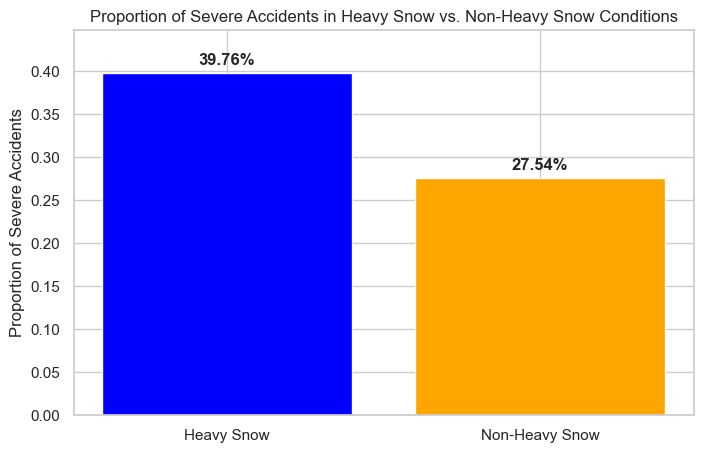

In [39]:
# Calculate proportions
prop_heavy_snow = severe_heavy_snow / total_heavy_snow if total_heavy_snow > 0 else 0
prop_non_heavy_snow = severe_non_heavy_snow / total_non_heavy_snow if total_non_heavy_snow > 0 else 0

# Bar plot
proportions = [prop_heavy_snow, prop_non_heavy_snow]
labels = ['Heavy Snow', 'Non-Heavy Snow']

plt.figure(figsize=(8, 5))
plt.bar(labels, proportions, color=['blue', 'orange'])
plt.ylim(0, max(proportions) + 0.05)  # Add some padding to the y-axis for better visualization
plt.ylabel('Proportion of Severe Accidents')
plt.title('Proportion of Severe Accidents in Heavy Snow vs. Non-Heavy Snow Conditions')

# Display proportions above bars
for i, prop in enumerate(proportions):
    plt.text(i, prop + 0.01, f"{prop:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.show()

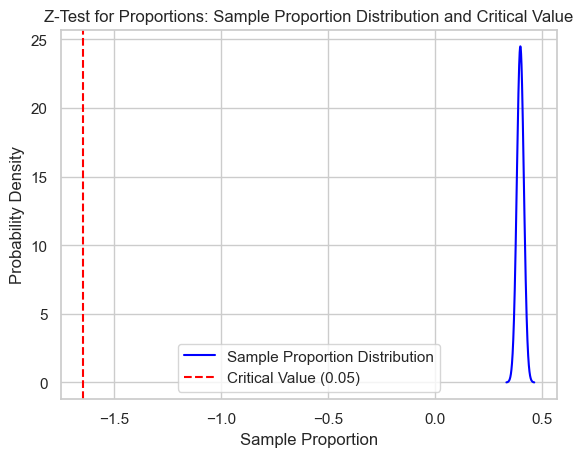

In [40]:
# Define sample and population values
sample_proportion = severe_heavy_snow / total_heavy_snow  # Sample proportion of severe accidents in heavy snow conditions
population_proportion = (severe_heavy_snow + severe_non_heavy_snow) / (total_heavy_snow + total_non_heavy_snow)  # Overall severe accident proportion

# Standard error calculation
sample_size = total_heavy_snow
se = np.sqrt((population_proportion * (1 - population_proportion)) / sample_size)

# Critical value for the significance level (alpha)
alpha = 0.05
critical_value = norm.ppf(alpha)  # Z-score critical value for left tail

# Create a range of values for the x-axis centered around the sample proportion
x = np.linspace(sample_proportion - 4 * se, sample_proportion + 4 * se, 1000)

# Plot the normal distribution of the sample proportion
plt.plot(x, norm.pdf(x, sample_proportion, se), label='Sample Proportion Distribution', color='blue')

# Draw a vertical line at the critical value
plt.axvline(critical_value, color='red', linestyle='--', label=f'Critical Value ({alpha})')

# Shade the area to the left of the critical value for the rejection region
# plt.fill_between(x, 0, norm.pdf(x, sample_proportion, se), where=(x <= critical_value), color='red', alpha=0.2, label='Rejection Region')

# Add labels, legend, and title
plt.xlabel('Sample Proportion')
plt.ylabel('Probability Density')
plt.title('Z-Test for Proportions: Sample Proportion Distribution and Critical Value')
plt.legend()

# Show the plot
plt.show()

## 4.3) T test for correlation

In [41]:
columns_to_analyze = [('Humidity(%)', 'Temperature(F)')]

alpha = 0.05

def correlation_test(column1, column2):
    # Calculate the correlation coefficient and p-value
    r, _ = stats.pearsonr(df[column1], df[column2])
    
    # Calculate sample size
    n = len(df)
    
    # Calculate the t-statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    
    # Calculate the p-value for the two-tailed test
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2))
    
    return r, t_stat, p_value

# Iterate through the pairs of columns
results = []
for col1, col2 in columns_to_analyze:
    r, t_stat, p_value = correlation_test(col1, col2)
    results.append((col1, col2, r, t_stat, p_value))
    # Print the results
    print(f"Columns: {col1} and {col2}")
    print(f"  Correlation Coefficient (r): {r}")
    print(f"  T-statistic: {t_stat}")

    # Decision based on p-value
    if p_value < alpha:
        print("  Reject the null hypothesis (H0): There is a significant correlation.")
    else:
        print("  Fail to reject the null hypothesis (H0): There is no significant correlation.")
    print()  

Columns: Humidity(%) and Temperature(F)
  Correlation Coefficient (r): -0.34860029635785794
  T-statistic: -305.2669781959981
  Reject the null hypothesis (H0): There is a significant correlation.



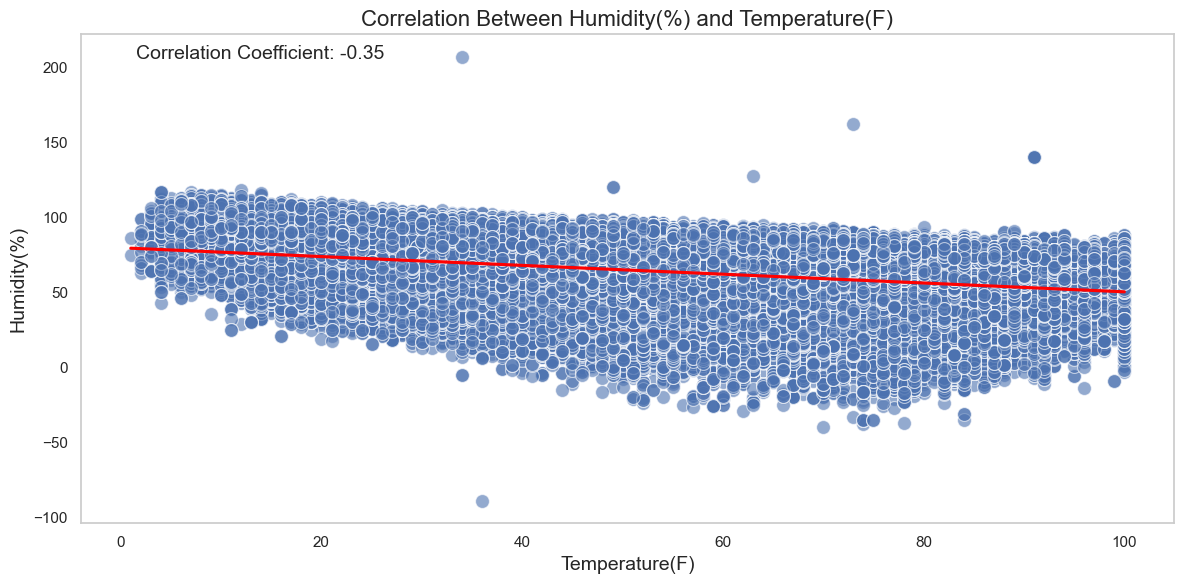

In [42]:
col1 = 'Humidity(%)'
col2 = 'Temperature(F)'

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(data=df, x=col1, y=col2, alpha=0.6, edgecolor='w', s=100)

sns.regplot(data=df, x=col1, y=col2, scatter=False, color='red', ci=None)

correlation_coefficient = df[col1].corr(df[col2])

plt.annotate(f'Correlation Coefficient: {correlation_coefficient:.2f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction', 
             fontsize=14, 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title(f'Correlation Between {col1} and {col2}', fontsize=16)
plt.ylabel(col1, fontsize=14)
plt.xlabel(col2, fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

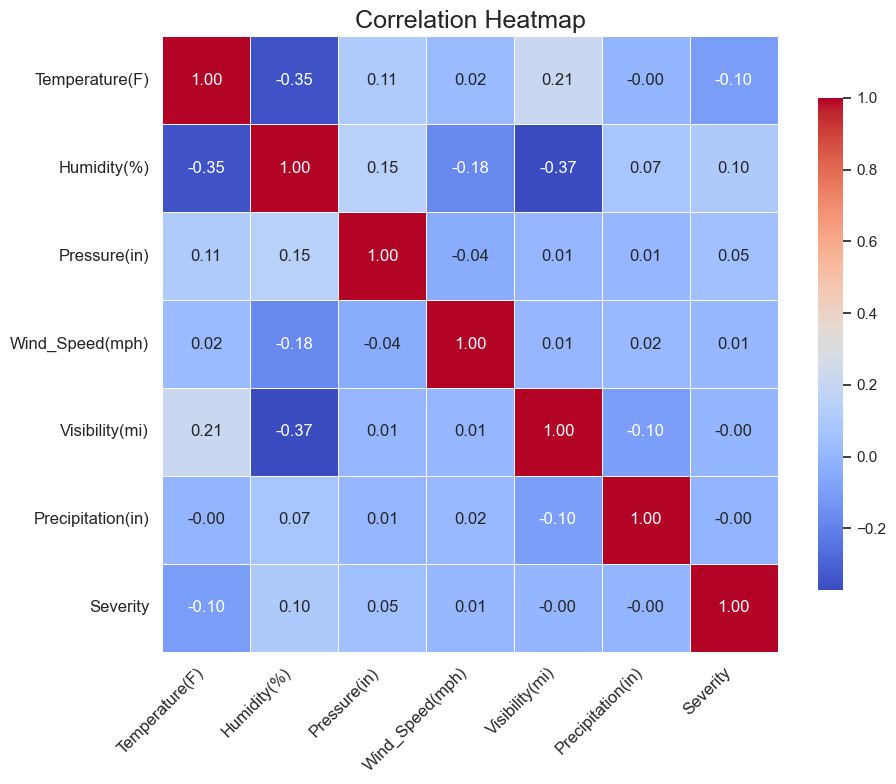

In [43]:
# Define continuous columns to analyze for correlation
continuous_columns = [
    'Temperature(F)', 
    'Humidity(%)', 
    'Pressure(in)', 
    'Wind_Speed(mph)', 
    'Visibility(mi)', 
    'Precipitation(in)', 
    'Severity'
]

# Calculate the correlation matrix
correlation_matrix = df[continuous_columns].corr()

# Set the style for the heatmap
sns.set(style='whitegrid')

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, 
                       annot=True, 
                       fmt=".2f", 
                       cmap='coolwarm', 
                       square=True, 
                       cbar_kws={"shrink": .8}, 
                       linewidths=.5)

# Customize the heatmap
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Show the heatmap
plt.show()

## 4.4) Z test for 1 population proportions

In [44]:
from statsmodels.stats.proportion import proportions_ztest

severe_accidents = df[df['Severity'].isin([3, 4])]

night_accidents = severe_accidents[severe_accidents['Sunrise_Sunset'] == 'Night'].shape[0]

total_severe_accidents = severe_accidents.shape[0]

# Calculate observed proportion
p_hat = night_accidents / total_severe_accidents
p_0 = 0.6  # Hypothesized population proportion for nighttime severe accidents

# Perform the Z-test for proportion
count = night_accidents
nobs = total_severe_accidents
z_stat, p_value = proportions_ztest(count, nobs, value=p_0, alternative='larger')

# Output results
print("Z-Statistic:", z_stat)
print("P-Value:", p_value)

# Conclusion based on significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Proportion of nighttime severe accidents is significantly greater than 0.6")
else:
    print("Fail to reject the null hypothesis: Proportion of nighttime severe accidents is not significantly greater than 0.6")


Z-Statistic: -288.1130152115506
P-Value: 1.0
Fail to reject the null hypothesis: Proportion of nighttime severe accidents is not significantly greater than 0.6


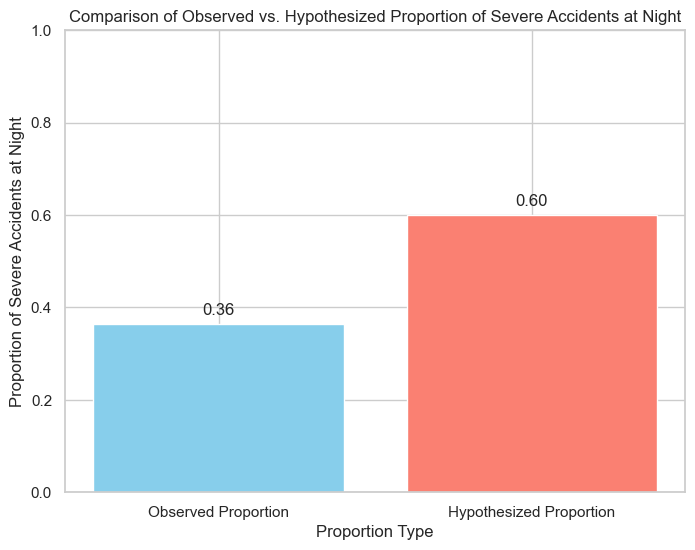

In [45]:
# Observed proportion of severe accidents at night
observed_proportion = night_accidents / total_severe_accidents
hypothesized_proportion = 0.6  # Hypothesized threshold for proportion of nighttime severe accidents

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Observed Proportion', 'Hypothesized Proportion'], 
        [observed_proportion, hypothesized_proportion], 
        color=['skyblue', 'salmon'])

# Add labels and title for clarity
plt.xlabel('Proportion Type')
plt.ylabel('Proportion of Severe Accidents at Night')
plt.title('Comparison of Observed vs. Hypothesized Proportion of Severe Accidents at Night')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for proportion range

# Annotate the bars with the actual proportion values
plt.text(0, observed_proportion + 0.02, f'{observed_proportion:.2f}', ha='center')
plt.text(1, hypothesized_proportion + 0.02, f'{hypothesized_proportion:.2f}', ha='center')

# Display the plot
plt.show()

## 4.5) T test for 2 population mean

In [46]:
from scipy.stats import ttest_ind

# Separate data into mild (Severity 1) and serious (Severity 4) accidents
mild_accidents = df[df['Severity'].isin([1])]
serious_accidents = df[df['Severity'].isin([4])]

# Extract 'Visibility(mi)' values for each group
mild_visibility = mild_accidents['Visibility(mi)'].dropna()
serious_visibility = serious_accidents['Visibility(mi)'].dropna()

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(mild_visibility, serious_visibility, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in visibility between mild and serious accidents.")
else:
    print("There is no significant difference in visibility between mild and serious accidents.")

T-statistic: 33.38720339477357
P-value: 1.281253898122376e-241
There is a significant difference in visibility between mild and serious accidents.


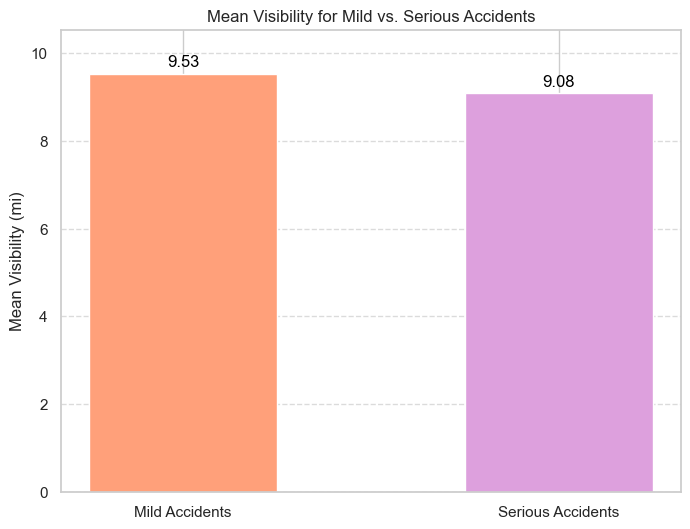

In [47]:
mean_mild_visibility = mild_visibility.mean()
mean_serious_visibility = serious_visibility.mean()

# Bar plot with mean value labels
plt.figure(figsize=(8, 6))
bars = plt.bar(['Mild Accidents', 'Serious Accidents'], 
               [mean_mild_visibility, mean_serious_visibility], 
               color=['#FFA07A', '#DDA0DD'],  
               width=0.5)  # Adjust bar width

# Adding labels
plt.ylabel('Mean Visibility (mi)')
plt.title('Mean Visibility for Mild vs. Serious Accidents')

# Adding grid for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust y-axis limits to provide space above bars
plt.ylim(0, max(mean_mild_visibility, mean_serious_visibility) + 1)

# Label the bars with their mean values
for bar, mean in zip(bars, [mean_mild_visibility, mean_serious_visibility]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, 
             f'{mean:.2f}', ha='center', va='bottom', color='black', fontsize=12)

plt.show()